In [59]:
import numpy as np
import dill
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
from flask import Flask,Blueprint,request,render_template,jsonify
from sklearn.feature_extraction.text import TfidfVectorizer
#from modules.dataBase import collection as db

#pipeline
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from catboost import CatBoostClassifier


from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
%matplotlib inline
import itertools

In [60]:
df = pd.read_csv("dataset.csv")
df['humor'].replace({False:0, True:1}, inplace=True)
df.head(5)

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",0
1,Watch: darvish gave hitter whiplash with slow ...,0
2,What do you call a turtle without its shell? d...,1
3,5 reasons the 2016 election feels so personal,0
4,"Pasco police shot mexican migrant from behind,...",0


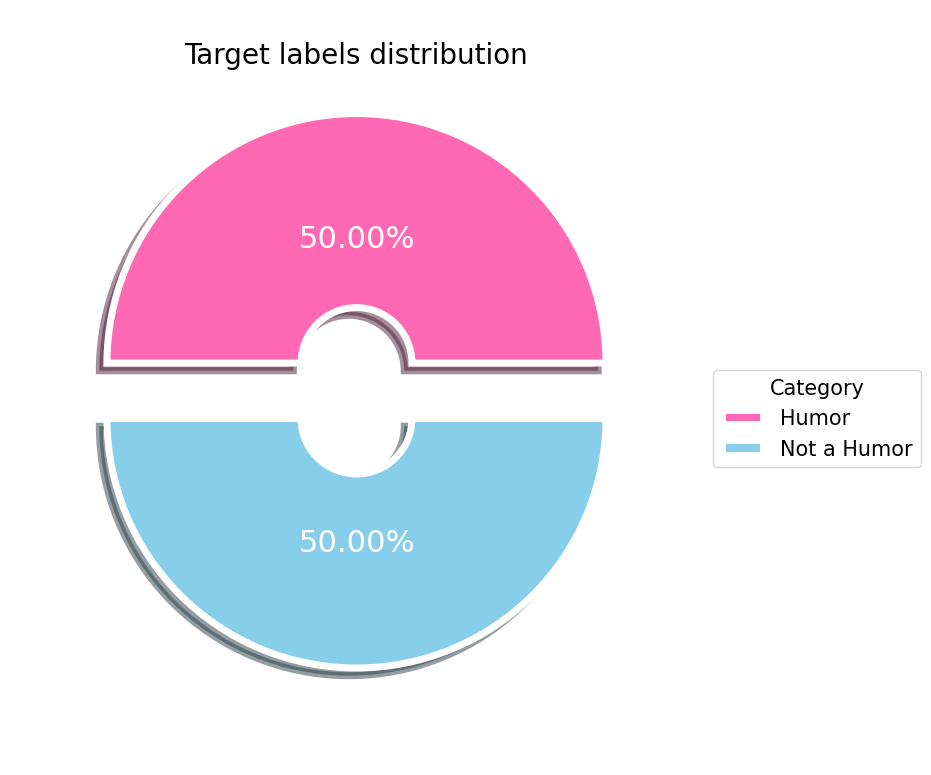

In [61]:
plt.subplots(figsize=(9, 9))

labels = "Humor","Not a Humor"
size = 0.7

wedges, texts, autotexts = plt.pie([len(df[df["humor"]==1]["humor"]),
                                    len(df[df["humor"]==0]["humor"])],
                                    explode = (0.2,0),
                                    textprops=dict(size= 22, color= "white"), # размер и цвет текста внутри диаграмы
                                    autopct="%.2f%%",
                                    pctdistance = 0.5, # положение текста значение процентов
                                    radius=0.9, 
                                    shadow = True, # добовляет эфект тени к диаграме
                                    wedgeprops=dict(width = size, edgecolor = "white", 
                                    linewidth = 5), # круг добовляет в центре
                                    startangle = 0, colors= ['hotpink', 'skyblue'])

plt.legend(wedges, labels, title="Category",loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))
plt.title("\nTarget labels distribution",fontsize=20)
plt.show()

In [62]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['humor']), df['humor'], test_size=0.33, random_state=42, stratify=df['humor'])
# save test
X_test.to_csv("X_test.csv", index=None)
y_test.to_csv("y_test.csv", index=None)

# save train
X_train.to_csv("X_train.csv", index=None)
y_train.to_csv("y_train.csv", index=None)

In [63]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]


class TextImputer(BaseEstimator, TransformerMixin):
    def __init__(self, key, value):
        self.key = key
        self.value = value

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X[self.key] = X[self.key].fillna(self.value)
        return X

### Сборка пайплайна

In [64]:
text = Pipeline([
                ('imputer', TextImputer('text', '')),
                ('selector', ColumnSelector(key='text')),
                ('tfidf', TfidfVectorizer(stop_words='english', use_idf=True, smooth_idf=True))
            ])

In [57]:

feats = FeatureUnion([text])


In [65]:
%%time
pipeline = Pipeline([
    ('features', text),
    ('classifier', CatBoostClassifier(silent=True, random_state=23, n_estimators=1540, max_depth=3))
])

pipeline.fit(X_train, y_train)

CPU times: total: 26min 18s
Wall time: 5min 17s


Pipeline(steps=[('features',
                 Pipeline(steps=[('imputer', TextImputer(key='text', value='')),
                                 ('selector', ColumnSelector(key='text')),
                                 ('tfidf',
                                  TfidfVectorizer(stop_words='english'))])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x0000010B7B601CD0>)])

### Сохрание модели в бинарном формате

In [66]:
with open("catbc.dill", "wb") as f:
    dill.dump(pipeline, f)

In [67]:
X_test = pd.read_csv("X_test.csv")
y_test = pd.read_csv("y_test.csv")

In [68]:
with open('catbc.dill', 'rb') as in_strm:
    pipeline = dill.load(in_strm)

In [71]:
with open('catbc.dill', 'rb') as in_strm:
    pipeline = dill.load(in_strm)

In [72]:
preds = pipeline.predict_proba(X_test)[:, 1]

pred_df = pd.DataFrame({'preds': preds})
pred_df.to_csv("test_predictions.csv", index=None)

In [73]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.47380673951815233, F-Score=0.851, Precision=0.806, Recall=0.903


In [74]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[25808  7192]
 [ 3211 29789]]


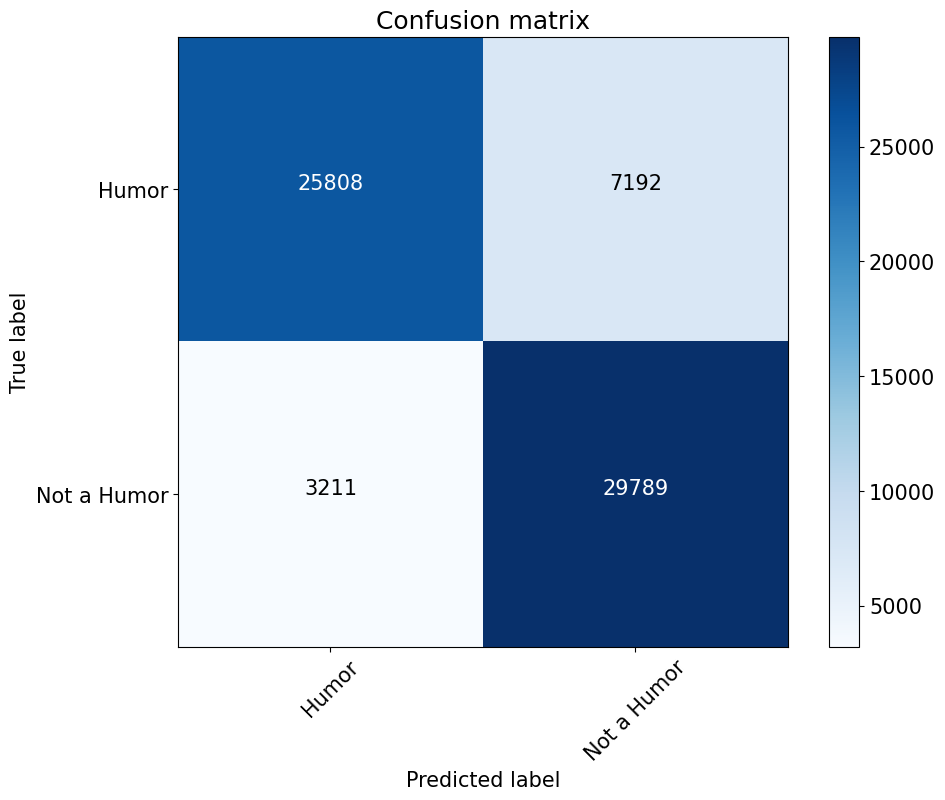

In [75]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds >= thresholds[ix])
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Humor', 'Not a Humor'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [83]:
df['text'][2]

'What do you call a turtle without its shell? dead.'

In [84]:
# Обработчики и запуск Flask
app = Flask(__name__)

@app.route("/", methods=["GET"])
def general():
    return "Welcome to prediction process"

@app.route('/predict', methods=['POST'])
def predict():
    data = {"success": False}
    # ensure an impipeline
    request_json = request.get_json()

    if request_json["text"]:
        text = request_json['text']
        
    
    df_for_pred = pd.DataFrame({"text": [str(text)]})
    print(df_for_pred)
    preds = pipeline.predict_proba(df_for_pred)
    print(preds[:, 1])
    data["predictions"] = preds[:, 1][0]
    data["text"] = text
        # indicate that the request was a success
    data["success"] = True
    print('OK')


        # return the data dictionary as a JSON response
    return jsonify(data)

if __name__ == '__main__':
    app.run(debug=False, port=5000)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [19/Sep/2023 21:26:05] "POST /predict HTTP/1.1" 200 -


                                                text
0  What do you call a turtle without its shell? d...
[[0.396065 0.603935]]
OK


127.0.0.1 - - [19/Sep/2023 21:34:16] "POST /predict HTTP/1.1" 200 -


                                                text
0  Quoting monty python and the holy grail is as ...
[[0.52619326 0.47380674]]
OK


127.0.0.1 - - [19/Sep/2023 21:35:42] "POST /predict HTTP/1.1" 200 -


                                                text
0  What do most people do when they see a python ...
[[0.34618023 0.65381977]]
OK


127.0.0.1 - - [19/Sep/2023 21:36:13] "POST /predict HTTP/1.1" 200 -


                                                text
0  What do most people do when they see a python ...
[[0.34618023 0.65381977]]
OK


127.0.0.1 - - [19/Sep/2023 21:38:13] "POST /predict HTTP/1.1" 200 -


                                                text
0  Youre odd she said. not even i replied. What d...
[[0.27318723 0.72681277]]
OK
                                           text
0  What has 4 eyes and cannot see? mississippi.
[[0.45939214 0.54060786]]
OK


127.0.0.1 - - [20/Sep/2023 08:56:17] "POST /predict HTTP/1.1" 200 -


# Обработчики и запуск Flask
app = Flask(__name__)

@app.route("/", methods=["GET"])
def general():
    return "Welcome to prediction process"

@app.route('/predict', methods=['POST', 'GET'])

def predict_info():
    return predict(request, 'predict_info.html')


def predict(request, name):
    if request.method == 'POST':
        
    data = {"success": False}
    # ensure an impipeline
    request_json = request.get_json()

    if request_json["text"]:
        text = request_json['text']
        
    
    df_for_pred = pd.DataFrame(text, columns='text')
    print(df_for_pred)
    preds = pipeline.predict_proba(df_for_pred)
    data["predictions"] = preds[:, 1][0]
    data["text"] = text
        # indicate that the request was a success
    data["success"] = True
    print('OK')


        # return the data dictionary as a JSON response
    return jsonify(data)


if __name__ == '__main__':
    app.run(debug=False, port=5000)